# Part 5: Toxicity

In this part, you will analyze a number of real-world social media comments and attempt to classify them as normal, toxic, or severely toxic. One can view such a multiclassification model as an example component in a content moderation system. The dataset was originally released as part of an open competition by the Google Jigsaw team, which went on to create the public [Jigsaw API](https://perspectiveapi.com) for toxic speech detection. 

**Learning objectives.** You will:
1. Use a Bag-Of-Words model to represent text data as count vectors.
2. Fit and validate a regularized text multiclassification model using logistic regression. 
3. Consider the problem of data imbalance and consider resampling and reweighting strategies to mitigate the problem. 
4. Read opinion pieces and articulate a position on the societal application of machine learning models for content moderation systems.

**Warning** Many of the comments contained in the data for this part **are offensive** -- the goal of the model you build will be to detect and help filter such comments. The comments in the data in no way represent the views of Duke University; the data were collected and made public by the [Google Jigsaw team](https://jigsaw.google.com/issues/). You may wish to avoid viewing the comments directly, and are not required to view them directly to complete this assignment.

## Task 1

The dataset `toxic.csv` included with this project is in the following format. The example below is artificial and not part of the dataset.

| id               | comment_text                          | toxic | severe_toxic | obscene | threat | insult | identity_hate |
|------------------|---------------------------------------|-------|--------------|---------|--------|--------|---------------|
| 0880df08u        | I love Duke! What a great University. | 0     | 0            | 0       | 0      | 0      | 0             |
| 08234hhf1 | You are a terrible person.            | 1     | 0            | 0       | 0      | 0      | 0             |
| 2843jdf42 | BLANK People are such EXPLETIVE, I hate them   | 1     | 1            | 1       | 0      | 1      | 1             |



Your first task is to transform this data into a format that you can use to build a predictive model that takes the `comment_text` as input and predicts whether the comment is normal (not toxic), toxic, or severely toxic.

Begin by reading the data. You [read the data into a Pandas Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), or you can use the [basic Python csv module](https://docs.python.org/3/library/csv.html).  NumPy also has a [data reading utility](https://numpy.org/doc/stable/user/how-to-io.html) but it may have difficulty working with the strings. 

You can format the predictive target in a separate NumPy array as an integer or a string, but should use a single value per comment. When a comment is labeled as both toxic and severely toxic, you should consider it severely toxic. You should not need to use the `id`, `obscene`, `threat`, `insult`, or `identity_hate` features.



Next, you should develop a **bag-of-words** (BOW) representation of the training data comments using [count vectorization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). There are a number of parameter choices to consider that may impact the utlimate model you build. Consider in particular:
- `token_pattern`: A regular expression pattern used to determine what counts as a *token* in the vocabulary. The default value will count any space/punctuation delimited string of two or more alphanumeric (letters or numbers) unicode characters (including non-English characters) as a token to be counted in the vocabulary. In addition to the default, you can use the parameter setting `token_pattern=r"(?u)\b[a-zA-Z][a-zA-z]+\b"` to restrict to English alphabetic characters only. You don't need to learn arbitrary regular expressions for this assignment, but you can see more about [regular expressions in Python here](https://docs.python.org/3/library/re.html) if you are interested.
- `binary`: By default set to `False`, the number of occurrences of each token will be counted for each comment. If set to `binary=True` then only a `1` or `0` will be recorded depending on whether the token occurs at all in the given comment.
- `min_df` and `max_df`: If set to a floating point number, these parameters control the dropping of very uncommon or very common tokens from the vocabulary. If `max_df` is set to `0.5`, for example, then any tokens appearing in 50% or more of all comments will be discarded, and if `min_df` is set to `0.0001` then any tokens appearing in less than 0.01% of all comments will be discarded. By default nothing is discarded.


Experiment to find a setting of these parameters with a small but informative and useful vocabulary of **at most 10 thousand tokens** in your BOW model. When you are finished you should have two NumPy arrays: a `X` consisting of a row for each comment and a column for each word in the vocabulary (at most 10 thousand), storing the count of that word in the comment, and a `y`consisting of a single value per index `i` corresponding to whether the comment representing in row `i` of `X` is normal, toxic, or very toxic. 

Print the number of rows and columns of `X` and `y`. Briefly explain each of the aforementioned parameters, explaining why you chose the value that you did.

In [ ]:
# Write code for task 1 here
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

data  = pd.read_csv("toxic.csv")
data.head()


data['label'] = np.where(data['severe_toxic'] == 1, 2, np.where(data['toxic'] == 1, 1, 0))

vectorizer = CountVectorizer(
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b", 
    max_df=0.5, 
    min_df=0.0001, 
    max_features=10000)

X = vectorizer.fit_transform(data['comment_text'])

y = data['label'].values

print(f"X: {X.shape}")
print(f"y: {y.shape}")

For the aforementioned parameters, we followed the recommended instructions, and chose the suggestions that the problem listed. For token pattern, we restricted our regex to English characters only, which helps filter out non-word tokens like numbers or punctuation marks. We followed the recommendation of setting max frequency to 0.5, because this limits the inclusion of words that appear in more than 50% of the comments that include common/filler words that occur across a large portion of the dataset and might not provide useful information for classifying toxicity. Similarly, we set min frequency to 0.0001, since this excludes rare words that occur in very few comments and won't generalize or fit well into the model. Lastly, we restrict the vocabulary to 10,000 words, since we want to find enough information without overfitting with too many features. 

## Task 2

As usual, randomly split the input data into a [train and test set](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), with 30% of the data reserved for testing. Use a random seed of `2024` for reproducibility of the results.

Build a multiclassification [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to predict whether a comment is normal, toxic, or severely toxic. Use l2 regularization (the default). To determine a good setting of the parameter `C`, compute and visualize the [Validation Curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html#validationcurvedisplay) for **at least five values of `C` between 0.001 and 1.** Note that the Scikit-Learn implementation of [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) or [from_estimator](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html#sklearn.model_selection.ValidationCurveDisplay.from_estimator) will compute the validation scores for visualizing on the curve using 5-fold cross validation by default. 

Based on the validation curve, briefly explain what value of `C` you select for your model. Then compute and visualize the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) for your model's predictions on the test set. Note that the matrix will be a 3 x 3 since there are three classes in this task.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, validation_curve, ValidationCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)

X_train_small, y_train_small = resample(X_train, y_train, n_samples=5000, random_state=2024)

param_range = np.logspace(-3, 0, 3)

logRegression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, n_jobs=-1, warm_start=True)

ValidationCurveDisplay.from_estimator(
    logRegression, 
    X_train,
    y_train,
    param_name='C',
    param_range=param_range,
    cv=3 

)
plt.show()

logRegression.fit(X_train, y_train)

y_pred = logRegression.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.show()


The C we select will be the second C value, 0.01. This is because the cross validation score plateaus, and increasing C will only make the difference between the testing and training scores bigger.

## Task 3

Carefully inspect the confusion matrix of your final model from task 2. You should observe that, while the overall accuracy is reasonably high (likely above 90%), the accuracy is worst on comments that are severely toxic! You should also note that there are far fewer of these kinds of examples compared to normal comments. This phenomenon is called *data imbalance*.

For this task, experiment each of the following methods for addressing data imbalance:
1. *Resampling*: Rather than the original train set, create a new train set that has a roughly equal number of normal, toxic, and severely toxic comments. You can do so by *upsampling* -- adding additional examples of random toxic and severely toxic comments by repeating the examples you have in the training data, or by *downsampling* -- choosing only a subset of your normal and toxic examples to create a balanced training data set. You can write the code yourself from scratch (in which case you might find the [NumPy Random package](https://numpy.org/doc/stable/reference/random/index.html) helpful) or use the scikitlearn [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html) functionality. You should not resample your test set; leave it unbalanced and representative of the original predictive task.
2. *Class reweighting*: Alternatively, you can leave the dataset alone but reweight the loss assosciated with errors on different classes for the model optimization. This is supported for [logistic regression in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) through the `class_weight` parameter. By default, the parameter is set to `None`, but setting it to `balanced` will result in optimization weights being set in inverse proportion to the frequency of the label (that is, less common classes like severely toxic are weighted more highly during the optimization of the logistic regression model).

Provide your implementations and report your results for each by computing and visualizing the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) on the test set. Use the same regularization parameter as in task 3. Select one of the results as your final model and briefly explain why you would select that, referencing the confusion matrices (and other metrics if you wish to compute them) and interpreting them in the context of the task to provide evidence for your choice.

C:\Users\micha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


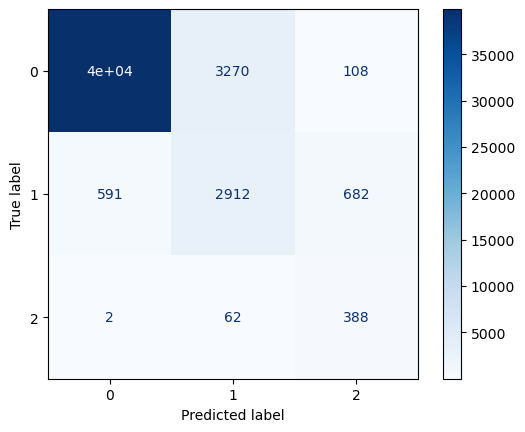

C:\Users\micha\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


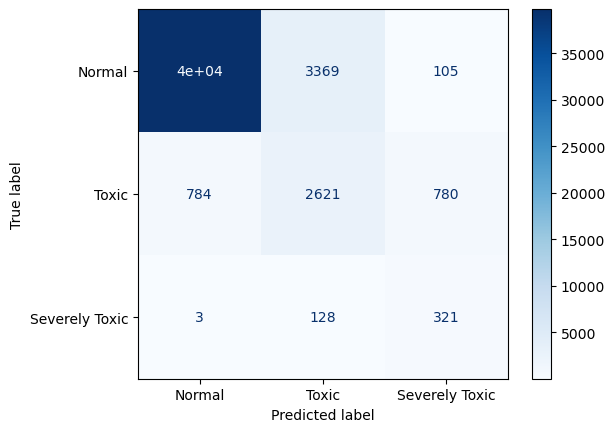

In [6]:
# Write code for task 3 here
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

normal = data[data['label'] == 0]
toxic = data[data['label'] == 1]
severe_toxic = data[data['label'] == 2]

toxic_upsampled = resample(toxic, replace=True, n_samples=len(normal), random_state=2024)
severe_toxic_upsampled = resample(severe_toxic, replace=True, n_samples=len(normal), random_state=2024)

balanced_data = pd.concat([normal, toxic_upsampled, severe_toxic_upsampled])
X_balanced = vectorizer.transform(balanced_data['comment_text'])
y_balanced = balanced_data['label'].values


logistic_model_upsampled = LogisticRegression(class_weight='balanced') 
logistic_model_upsampled.fit(X_balanced, y_balanced)

y_pred_upsampled = logistic_model_upsampled.predict(X_test)

cm_upsampled = confusion_matrix(y_test, y_pred_upsampled)
disp_upsampled = ConfusionMatrixDisplay(confusion_matrix=cm_upsampled)
disp_upsampled.plot(cmap=plt.cm.Blues)
plt.show()


# Train with class weights
model_weighted = LogisticRegression(C=0.01, class_weight='balanced', multi_class='multinomial', solver='lbfgs')
model_weighted.fit(X_train, y_train)

y_pred_weighted = model_weighted.predict(X_test)

cm_weighted = confusion_matrix(y_test, y_pred_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=['Normal', 'Toxic', 'Severely Toxic'])
disp_weighted.plot(cmap=plt.cm.Blues)
plt.show()


We believe that the class-weighted logistic regression model performs well overall, particularly in identifying normal comments, with around 40,000 correctly classified. However, about 3,369 normal comments were misclassified as toxic, which may occur when harsh language is used but not to a toxic extent. For toxic comments, the model correctly classified 2,621 but misclassified a significant portion as either normal or severely toxic, showing difficulty in distinguishing between toxicity levels. Our model shows improvement in identifying severely toxic comments, with 321 correctly classified, though some were still misclassified as toxic. The weighted model is selected as the final choice because it improves recall for severely toxic comments, a critical need in content moderation, while maintaining high accuracy on normal comments.

## Task 4

Identify the top 50 words in the vocabulary most strongly assosciated with toxicity by the model by inspecting the model coefficients (the `.coef_` attribute of the trained model). Using these findings, discuss some of the limitations of the BOW model for this task, explaining in particular why you would expect some false positives of normal texts incorrectly identified as toxic.

In [9]:
coefs = logistic_model_upsampled.coef_

feature_names = vectorizer.get_feature_names_out()

top_50_severe_toxic = np.argsort(coefs[2])[::-1][:50]  # Severely toxic class

print("\nTop 50 words for severely toxic comments:")
print([feature_names[i] for i in top_50_severe_toxic])



Top 50 words for severely toxic comments:
['fuck', 'fucking', 'shit', 'suck', 'ass', 'ck', 'stupid', 'dick', 'asshole', 'bitch', 'motherfucker', 'fucker', 'fuckin', 'idiot', 'faggot', 'cock', 'catholic', 'motherfucking', 'filthy', 'cking', 'cocksucker', 'bitches', 'head', 'piece', 'nazi', 'bastard', 'gay', 'cunt', 'off', 'dumb', 'assholes', 'big', 'anal', 'die', 'penis', 'sucking', 'idiots', 'hell', 'sucks', 'whore', 'dirty', 'damn', 'bashing', 'son', 'abuse', 'gonna', 'nobody', 'muslim', 'hate', 'sex']


The top 50 words in the vocabulary most strongly associated with toxicity include some unexpected entries, like "catholic" or "son". This is because these words may be used in some contexts for toxicity, but may not actually be the toxic words themselves. Furthermore, the model can't capture the order of certain words, like a "not" before a toxic word. This is why the BOW model ranks these words as strongly toxic although they are false positives.

# Task 5

Machine learning continues to be applied for content moderation to detect and remove hate speech. For example, read [Meta's discussion](https://ai.meta.com/blog/ai-advances-to-better-detect-hate-speech/) of AI hate speech detection advances at the company. There is an obvious advantage to automated machine learning models to deal with the scale of data on modern social media platforms. Others are skeptical about relying on machine learning models for this purpose. For example, also read [A Brave New World of Mediated Online Discourse](https://cacm.acm.org/opinion/a-brave-new-world-of-mediated-online-discourse/), a 2022 opinion piece in the Communications of the ACM (the leading computer science professional society).

In 2-3 paragraphs, take a position on the question "Should machine learning models be used to automatically detect and/or remove toxic speech from social media platforms?" Briefly substantiate your position referencing the above articles or other sources of your own choosing.

We believe machine learning should be used in mediation to detect or remove toxic speech on social media platforms, but with careful oversight and a balanced approach. Like Meta's discussion, models for identifying patterns of hate speech and toxic behavior can help remove harmful content quickly, creating a safer online environment. Their current ability to learn and improve from new data makes us hopeful that it will be successful in moderating large-scale online communities.

However, machine learning should not be the only way for content moderation. Given the complexity and nuance of language, automated systems can misinterpret context, leading to false positives, where critical discussions are mistakenly flagged as toxic. To address this, moderators should work alongside machine learning models to review edge cases, providing the necessary context that algorithms might miss. Thus, this hybrid approach will ensure that toxic speech is dealt with efficiently while protecting free speech and minimizing over-censorship.